# The Detrended Stack

The purpose of this notebook is to reproduce the detrended stack and synthetic stack from the paper. 

**Note:** This notebook assumes the existence of pickle files that need to have been created previously. If you are running this notebook on your machine, make sure you've successfully run both of the notebooks in the `Loading Data` folder.

In [6]:
import pickle
import os
from tqdm import tqdm

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import matplotlib.transforms as transforms

from matplotlib.ticker import FormatStrFormatter
from pylipd.lipd import LiPD

In [7]:
with open('../../data/pickle/preprocessed_series_dict.pkl','rb') as handle:
    preprocessed_series_dict = pickle.load(handle)

with open('../../data/pickle/preprocessed_ens_dict.pkl','rb') as handle:
    preprocessed_ens_dict = pickle.load(handle)

We begin with the real series, loading the necessary data and sorting by latitude.

In [8]:
lat_dict = {series.lat:series.label for series in preprocessed_series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
preprocessed_series_dict = {label:preprocessed_series_dict[label] for label in sort_label} #Sort by latitude
preprocessed_ens_dict = {label:preprocessed_ens_dict[label] for label in sort_label} #Sort by latitude

Now we plot:

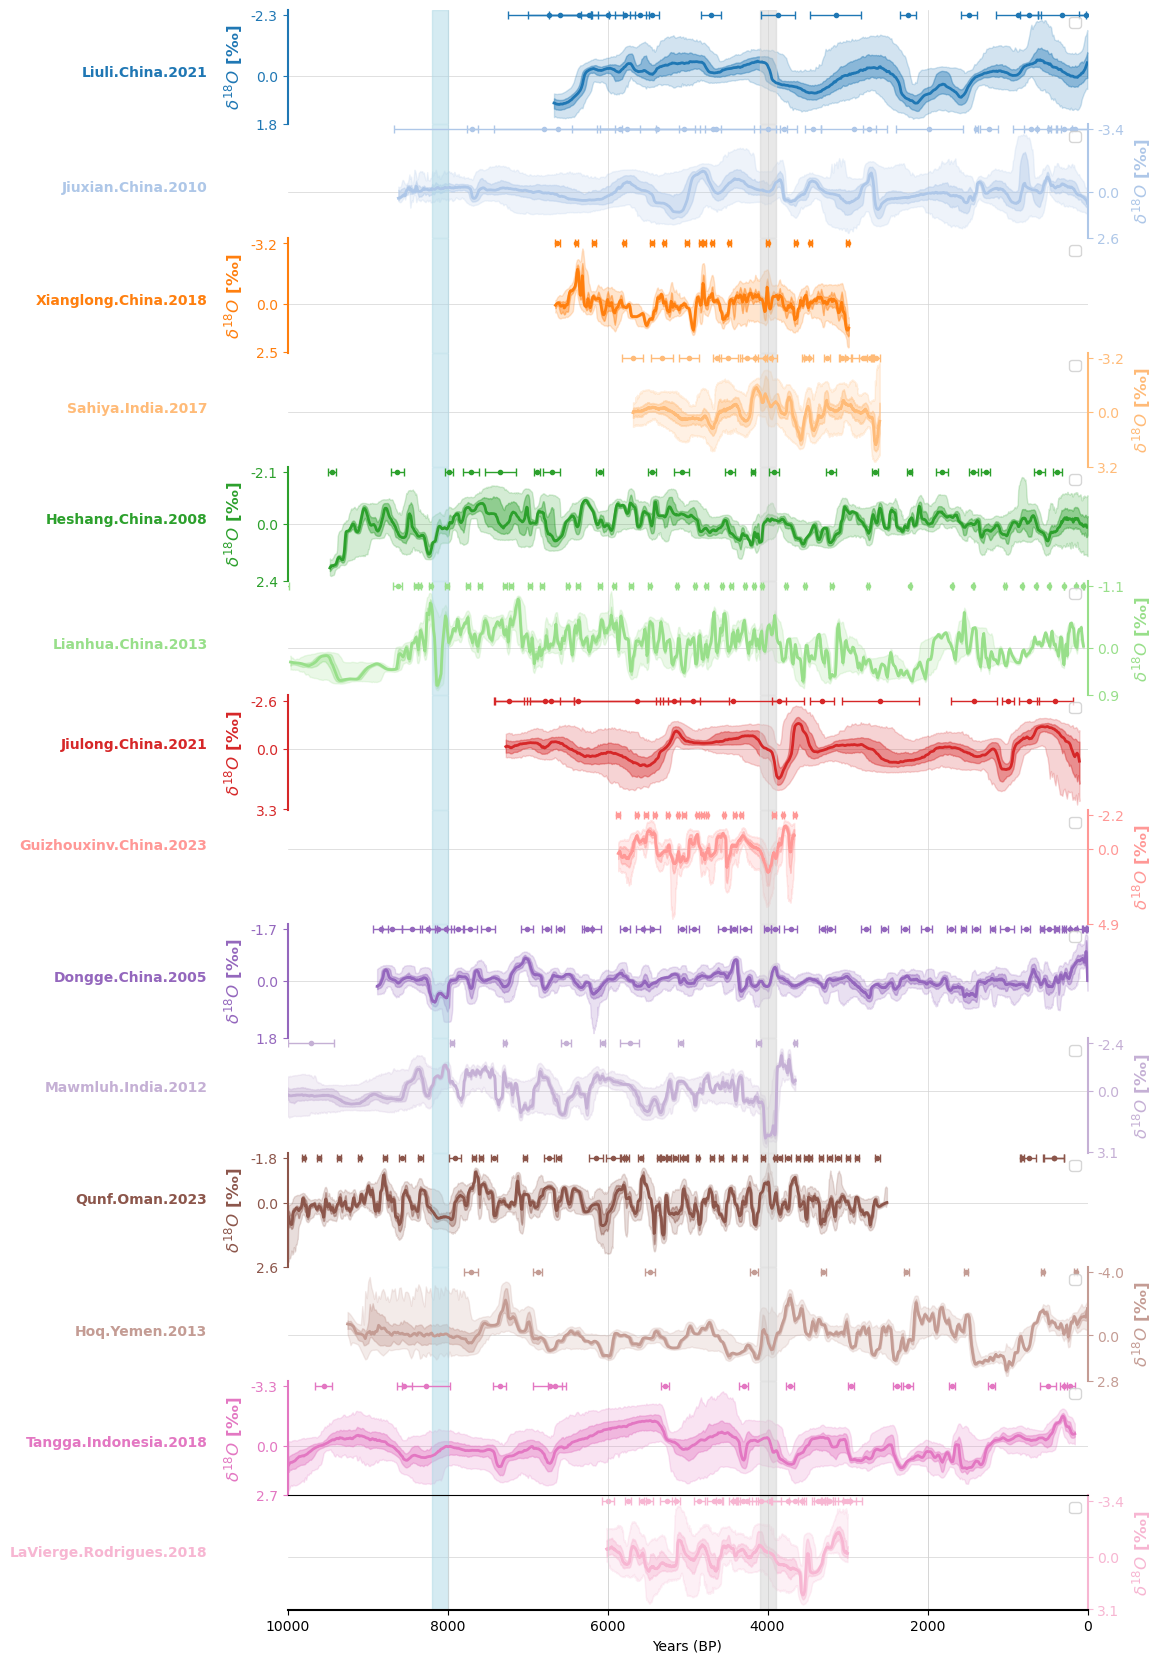

In [9]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Create a color palette with the same number of colors as the length of preprocessed_ens_dict
colors = sns.color_palette('tab20', n_colors=len(preprocessed_ens_dict))

# Iterate over each pair in preprocessed_ens_dict
for idx, pair in enumerate(preprocessed_ens_dict.items()):
    color = colors[idx]
    label, ens = pair

    cave = label.split('.')[0]
    dating_age = pd.read_csv(f'../../data/CSV/dating_age/{cave}.csv')[cave].to_numpy()
    dating_error = pd.read_csv(f'../../data/CSV/dating_error/{cave}.csv')[cave].to_numpy()
    
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])
    
    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)
    
    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)
    
    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
    
    # Add error bars to the plot based on the label
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(dating_age[0::2], [ylim[0]] * len(dating_age[0::2]), xerr=dating_error[0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(dating_age[1::2], [ylim[0] + offset] * len(dating_age[1::2]), xerr=dating_error[1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(dating_age[0::3], [ylim[0]] * len(dating_age[0::3]), xerr=dating_error[0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(dating_age[1::3], [ylim[0] + offset] * len(dating_age[1::3]), xerr=dating_error[1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(dating_age[2::3], [ylim[0] - offset] * len(dating_age[2::3]), xerr=dating_error[2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(dating_age, [ylim[0]] * len(dating_age), xerr=dating_error, color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    
    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)
    ax[idx].axvspan(8200,8000,color='lightblue',alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

To create synthetic versions of our ensembles, we substitute the real data with AR(1) noise that has a synthetic event with a magnitude of our choosing.

In [10]:
# define the function for the spike
def spike(t,delta,A):
    ''' Function to create a spike
        t : float
            time
        A : float
            amplitude
        delta : float
            parameter for the curve'''
    f=1/(2*(len(t)-1))
    y = (A/np.arctan(1/delta))*np.arctan(np.sin(2*np.pi*t*f)/delta)
    return y

# define a function to add a spike to a series
def add_spike(series,xstart,xend,A,method='smooth'):
    '''Function to add a spike to a pyleoclim series
    
    Parameters
    ----------

        series : pyleo.Series; 
            the series to which the spike will be added
        xstart : float
            the starting year of the spike
        xend : float
            the ending year of the spike
        A : float
            the amplitude of the spike
        method : str
            "smooth": add a spike by spike;
            otherwise, directly add values of A at each timestep'''
    new_series = series.copy()
    x = new_series.time
    y = new_series.value
    if method=='smooth':
        y[(x>=xstart)&(x<=xend)] += spike(np.arange(0,sum((x>=xstart)&(x<=xend))),0.02,A)
    else:
        y[(x>=xstart)&(x<=xend)] += [(x>=xstart)&(x<=xend)]+np.full(xend-xstart+1,A)
    new_series.value = y
    return new_series

This step is quite similar to the one we took in the `Load_Data_Pyleoclim` notebook, though this time we're going to be creating our own signal, rather than using real data. We will still use the real chronologies though.

In [16]:
data_path = '../../data/LiPD/full'
D = LiPD()
D.load_from_dir(data_path)
lipd_records = D.get_all_dataset_names()

synthetic_ens_dict = {}

holocene_bounds = (0,10000)

for record in tqdm(lipd_records):
    D = LiPD()
    D.load(os.path.join(data_path,f'{record}.lpd'))
    df = D.get_timeseries_essentials().iloc[0]
    series = pyleo.GeoSeries(
        time = df['time_values'],
        value=df['paleoData_values'],
        time_name = 'Age',
        time_unit = 'yrs BP',
        value_name = r'$\delta^{18} O$',
        value_unit = u'‰',
        label=record,
        lat = df['geo_meanLat'],
        lon=df['geo_meanLon'],
        archiveType='speleothem',
        dropna=False,
        verbose = False   
    )

    processed_series = series.slice(holocene_bounds).interp().standardize().detrend(method='savitzky-golay')
        
    #Fit AR1 model
    g = pyleo.utils.ar1_fit(y=processed_series.value,t=processed_series.time)

    #Generate surrogate values according to ar1 model and the unprocessed series time axis
    surr_value = pyleo.utils.tsmodel.ar1_model(t=series.time,tau=g)
    surr_series = pyleo.Series(series.time,surr_value,verbose=False)

    #Set a signal to noise ratio
    sn = 2
    surr_spike_series = add_spike(surr_series,3900,4100,np.std(surr_series.value)*sn)

    ens_df = D.get_ensemble_tables().iloc[0]
    ens_series_list = []
    processed_ens_series_list = []
    for i in range(1000): #We know there are 1000 ensemble members
        ens_series = pyleo.GeoSeries(
            time = ens_df['ensembleVariableValues'].T[i],
            value= surr_spike_series.value,
            time_name = 'Age',
            time_unit = 'yrs BP',
            value_name = r'$\delta^{18} O$',
            value_unit = u'‰',
            label=record,
            lat = df['geo_meanLat'],
            lon=df['geo_meanLon'],
            archiveType='speleothem',
            dropna=False,
            verbose=False
        )
        ens_series_list.append(ens_series)

    synthetic_ens = pyleo.EnsembleSeries(ens_series_list)
    synthetic_ens_dict[record] = synthetic_ens

Loading 14 LiPD files


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


Loaded..


  0%|          | 0/14 [00:00<?, ?it/s]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


Loaded..


  7%|▋         | 1/14 [00:01<00:14,  1.13s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Loaded..


 14%|█▍        | 2/14 [00:05<00:35,  2.94s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Loaded..


 21%|██▏       | 3/14 [00:06<00:22,  2.06s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Loaded..


 29%|██▊       | 4/14 [00:07<00:16,  1.70s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Loaded..


 36%|███▌      | 5/14 [00:10<00:19,  2.13s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Loaded..


 43%|████▎     | 6/14 [00:12<00:16,  2.03s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Loaded..


 50%|█████     | 7/14 [00:13<00:13,  1.92s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Loaded..


 57%|█████▋    | 8/14 [00:18<00:16,  2.69s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Loaded..


 64%|██████▍   | 9/14 [00:20<00:13,  2.69s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Loaded..


 71%|███████▏  | 10/14 [00:22<00:09,  2.42s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Loaded..


 79%|███████▊  | 11/14 [00:24<00:06,  2.25s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Loaded..


 86%|████████▌ | 12/14 [00:27<00:04,  2.33s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Loaded..


 93%|█████████▎| 13/14 [00:29<00:02,  2.43s/it]

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Loaded..


100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


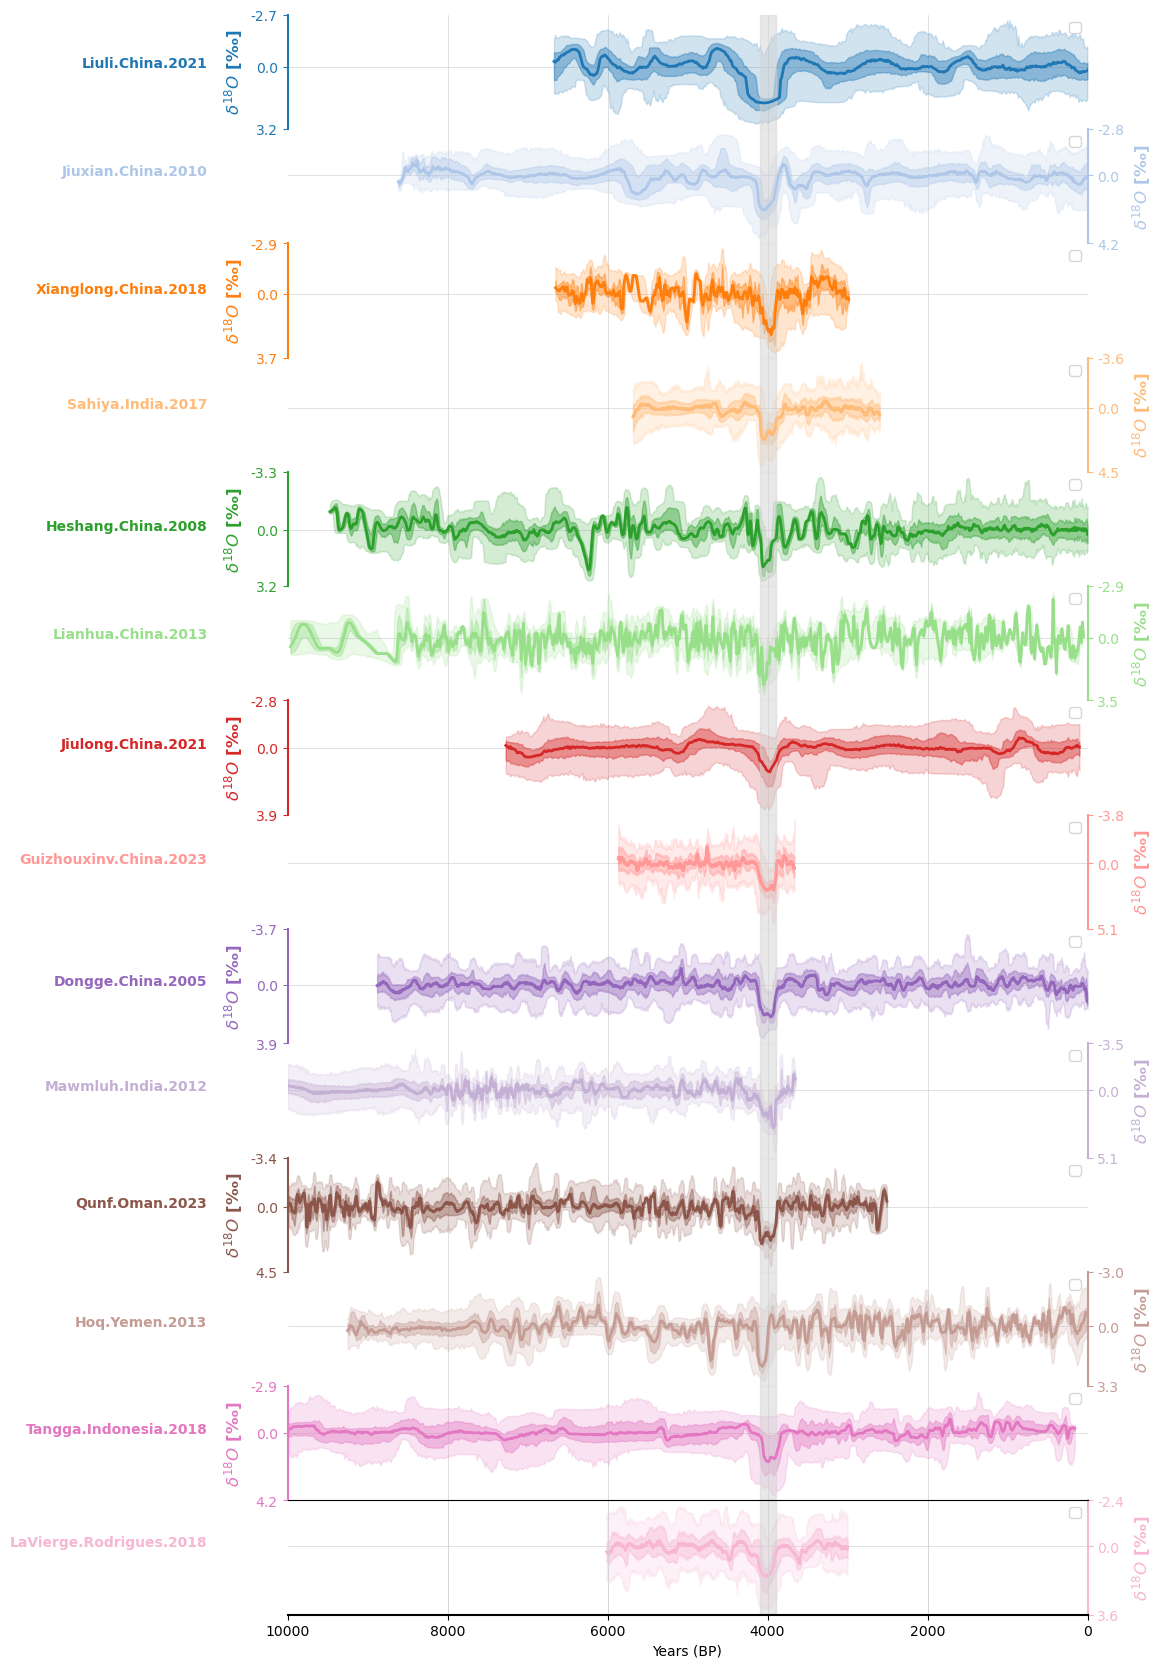

In [18]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

synthetic_ens_dict = {label:synthetic_ens_dict[label] for label in sort_label} #Sort by latitude

# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(synthetic_ens_dict))
for idx, pair in enumerate(synthetic_ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()